<a href="https://colab.research.google.com/github/bodadaniel/Missing_data/blob/main/Missing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and install packages

In [ ]:
pip install fancyimpute

In [2]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.impute import SimpleImputer
from fancyimpute import KNN, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm

# Load data

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [55]:
missing_values = ['.']

file_path = "/gdrive/MyDrive/Colab Notebooks/Missing_data/diabetes.xls"

df = pd.read_csv(file_path, na_values = missing_values)
df

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1.0
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63,0.0
764,2.0,122.0,70.0,27.0,NaN,36.8,0.340,27,0.0
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30,0.0
766,1.0,126.0,60.0,NaN,NaN,30.1,0.349,47,1.0


# Description of data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    float64
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                757 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [6]:
df.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Missing values

In [7]:
df_miss = pd.DataFrame(df.isna().mean()*100, columns=['missing_rate'])
df_miss

,missing_rate
Pregnant,0.000000
Glucose,0.651042
Diastolic_BP,4.557292
Skin_Fold,29.557292
Serum_Insulin,48.697917
BMI,1.432292
Diabetes_Pedigree,0.000000
Age,0.000000
Class,0.000000


In [8]:
df.Glucose.sort_values()

62     44.0
680    56.0
537    57.0
146    57.0
352    61.0
       ... 
75      NaN
182     NaN
342     NaN
349     NaN
502     NaN
Name: Glucose, Length: 768, dtype: float64

In [9]:
#Check only the first and last n elements
np.sort(df.Glucose)[np.hstack([np.arange(0, 3), np.arange(-3, 0)])]

array([44., 56., 57., nan, nan, nan])

In [56]:
#Modify BMI
df.BMI[df.BMI == 0] = np.nan
len(df.BMI[df.BMI.isnull()]) > 0

<ipython-input-56-cb7bbc3edc50>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.BMI[df.BMI == 0] = np.nan


True

#MSNO

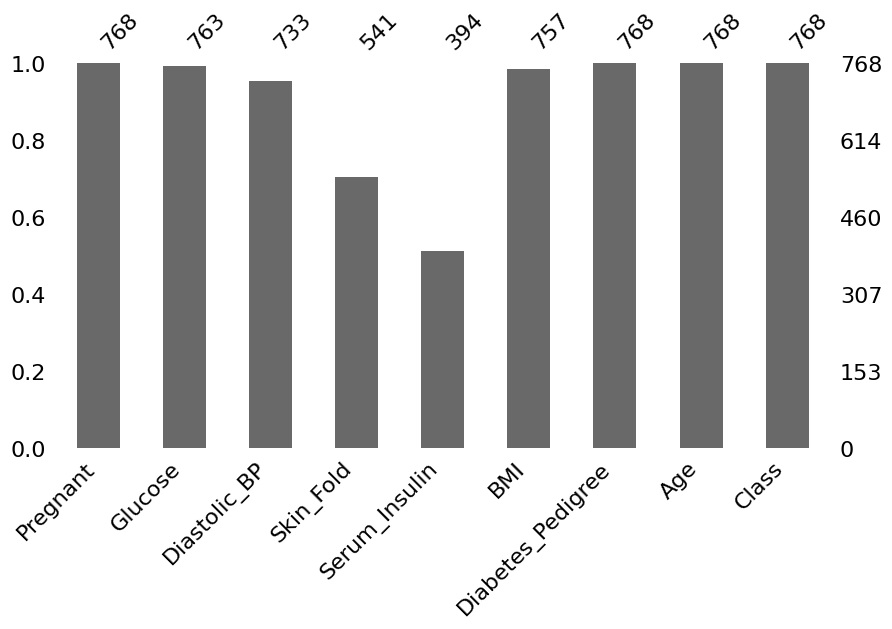

In [28]:
#missingness
msno.bar(df, figsize=(10, 5));

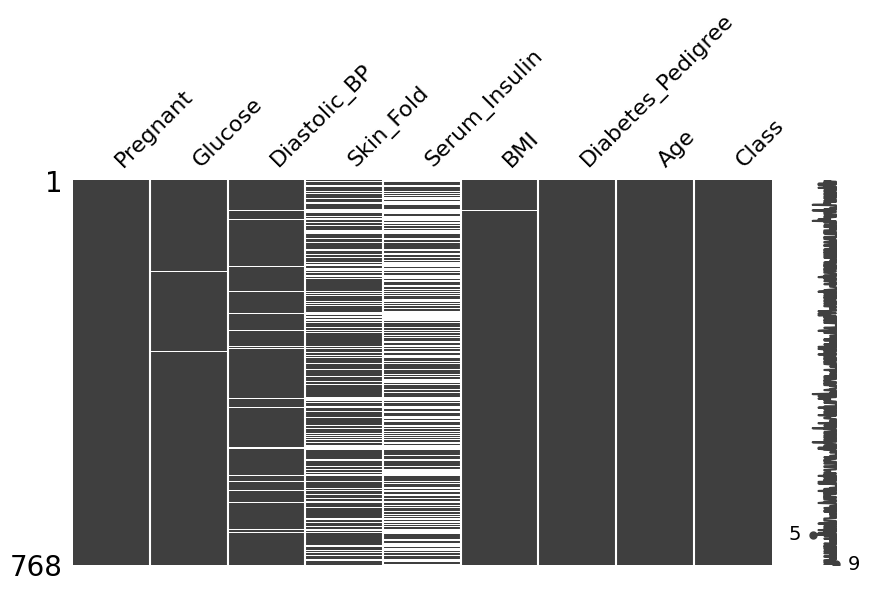

In [29]:
#type of missingness MAR, MCAR, MNAR
msno.matrix(df, figsize=(10, 5));

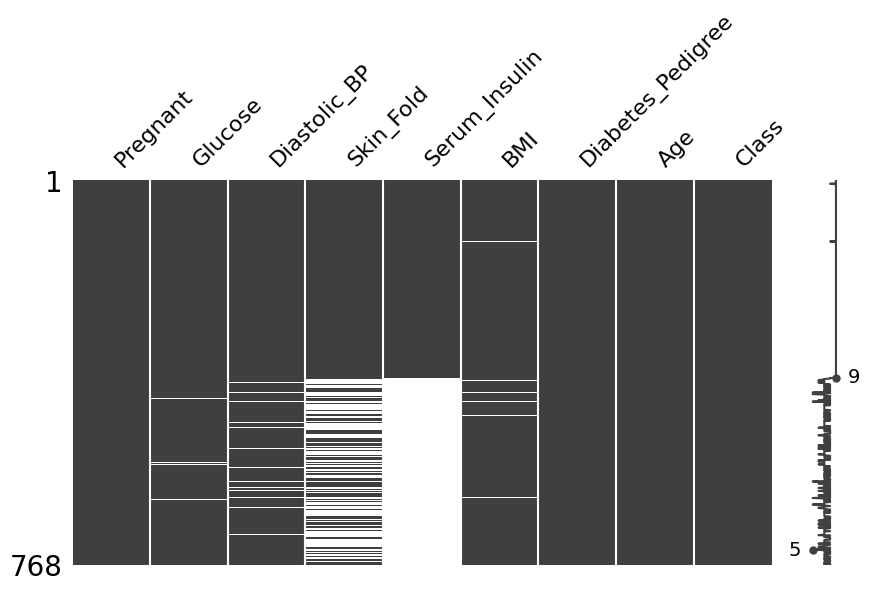

In [52]:
#MNAR
sorted_values = df.sort_values('Serum_Insulin')

# Visualize the missingness summary of sorted
msno.matrix(sorted_values, figsize=(10, 5));

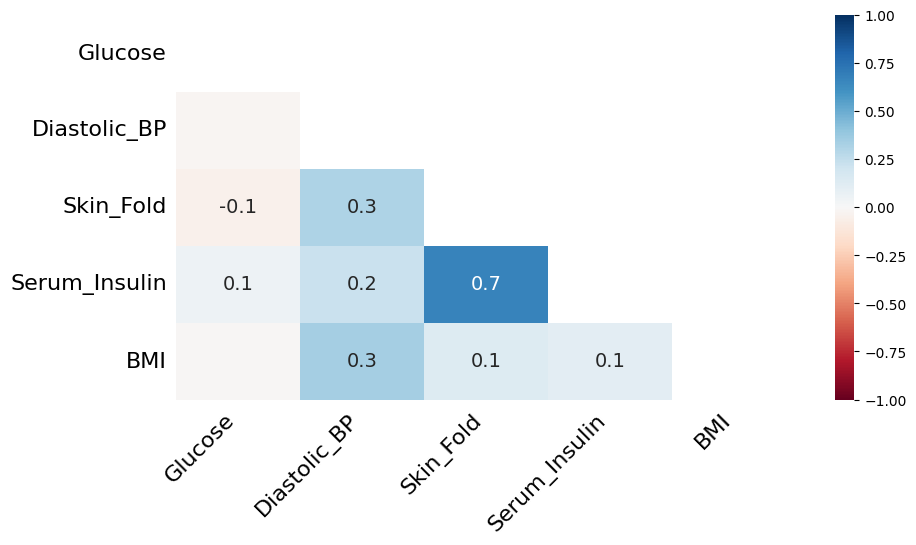

In [31]:
msno.heatmap(df, figsize=(10, 5));

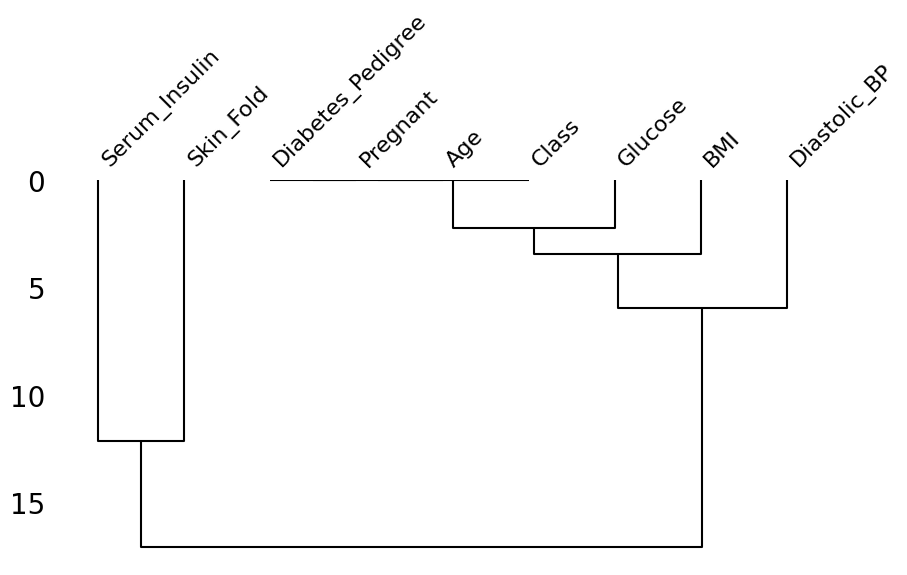

In [32]:
msno.dendrogram(df, figsize=(10, 5));

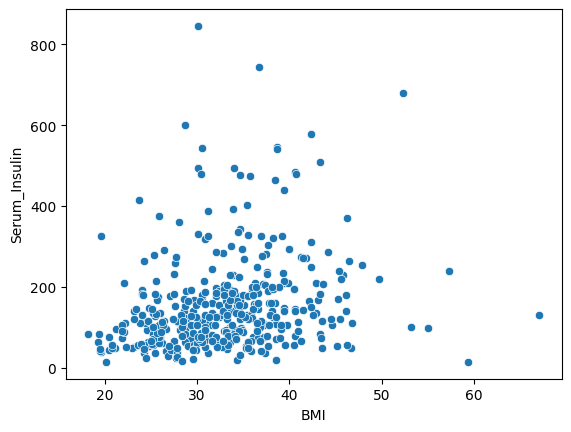

In [ ]:
sns.scatterplot(df, x = 'BMI', y = 'Serum_Insulin');

In [57]:
x = df.Serum_Insulin
df_copy = df.copy(deep=True)

miss_vals = {}

for col_name in df:
  col_value = df_copy[col_name]
  col_value_miss_index = col_value.isna()
  col_value[col_value_miss_index] = (np.random.rand(sum(col_value_miss_index)) - 2) \
                      * 0.075 * (col_value.max() - col_value.min()) + col_value.min()

  df_copy['col_name'] = col_value

  miss_vals[col_name] = col_value_miss_index


<ipython-input-57-407c141e88a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_value[col_value_miss_index] = (np.random.rand(sum(col_value_miss_index)) - 2) * 0.075 * (col_value.max() - col_value.min()) + col_value.min()
<ipython-input-57-407c141e88a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col_value[col_value_miss_index] = (np.random.rand(sum(col_value_miss_index)) - 2) * 0.075 * (col_value.max() - col_value.min()) + col_value.min()


In [58]:
miss_attr = list(df.columns[df_miss['missing_rate']>0])
miss_attr

['Glucose', 'Diastolic_BP', 'Skin_Fold', 'Serum_Insulin', 'BMI']

In [59]:
miss_attr_all_comb = list(itertools.combinations(miss_attr, 2))
(miss_attr_all_comb)

[('Glucose', 'Diastolic_BP'),
 ('Glucose', 'Skin_Fold'),
 ('Glucose', 'Serum_Insulin'),
 ('Glucose', 'BMI'),
 ('Diastolic_BP', 'Skin_Fold'),
 ('Diastolic_BP', 'Serum_Insulin'),
 ('Diastolic_BP', 'BMI'),
 ('Skin_Fold', 'Serum_Insulin'),
 ('Skin_Fold', 'BMI'),
 ('Serum_Insulin', 'BMI')]

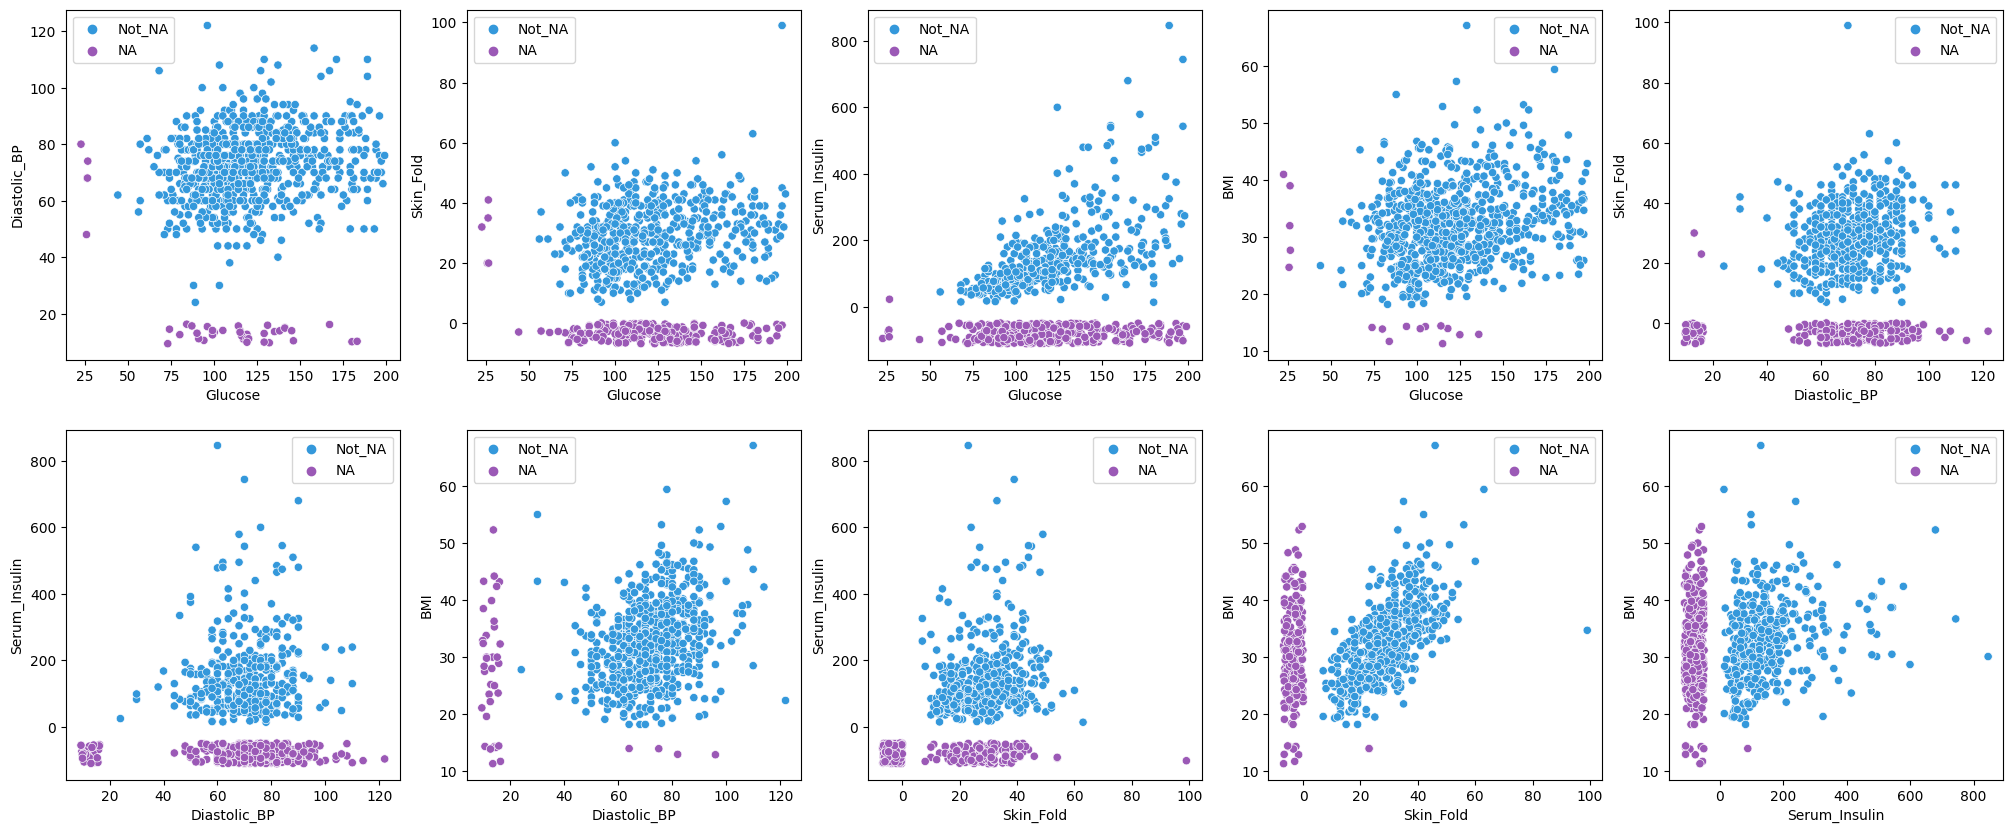

In [60]:
fig, axs = plt.subplots(2, 5, figsize=(25,10))

for var, ax in zip(miss_attr_all_comb, axs.flatten()):
  sns.scatterplot(df_copy,
                  x = var[0],
                  y = var[1],
                  hue = ['NA' if x == True else 'Not_NA' for x in (miss_vals[var[0]] | miss_vals[var[1]])],
                  ax = ax,
                  palette = dict(NA="#9b59b6", Not_NA="#3498db"),
                  hue_order = ['Not_NA', 'NA'] );

In [61]:
df2 = df.dropna(subset=['Glucose'], how='any')

In [62]:
df2.isna().sum()

Pregnant               0
Glucose                0
Diastolic_BP          35
Skin_Fold            227
Serum_Insulin        370
BMI                   11
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

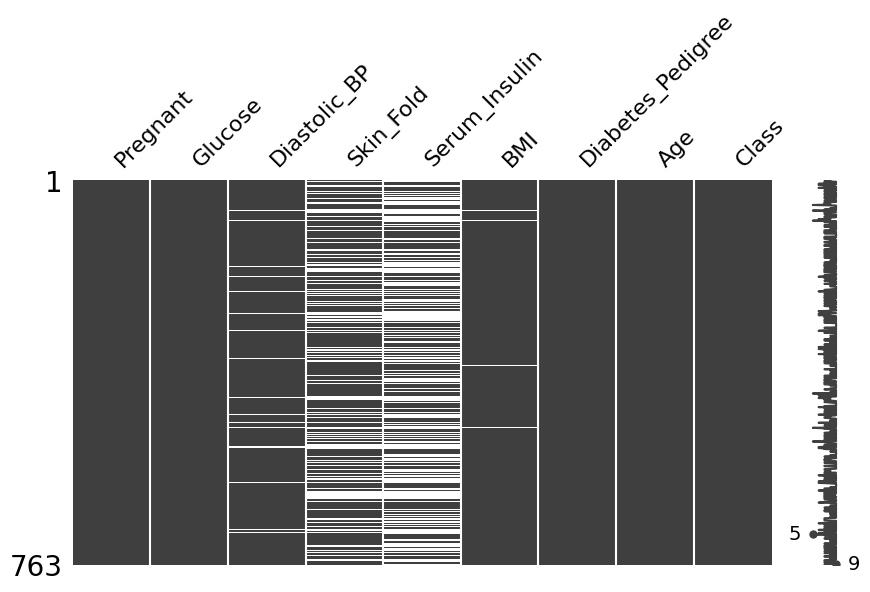

In [63]:
msno.matrix(df2, figsize=(10, 5));

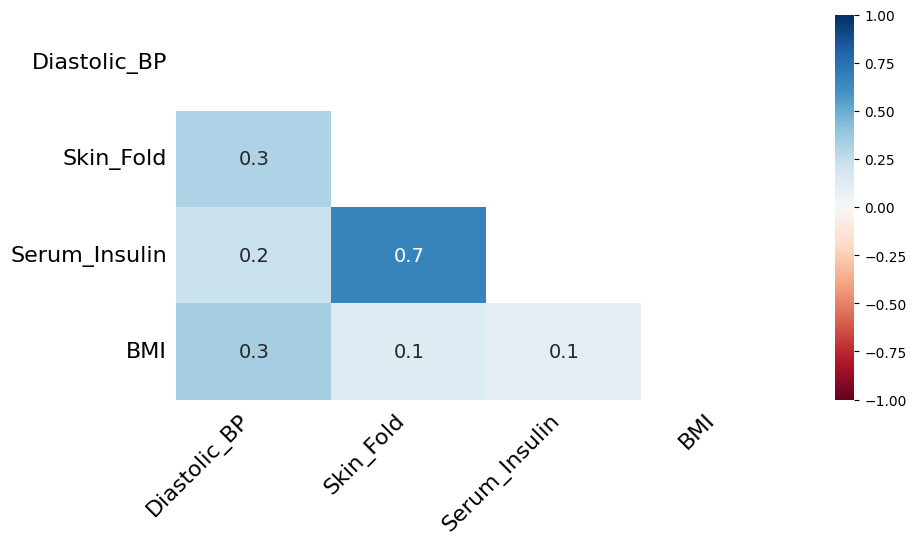

In [64]:
msno.heatmap(df2, figsize=(10, 5));

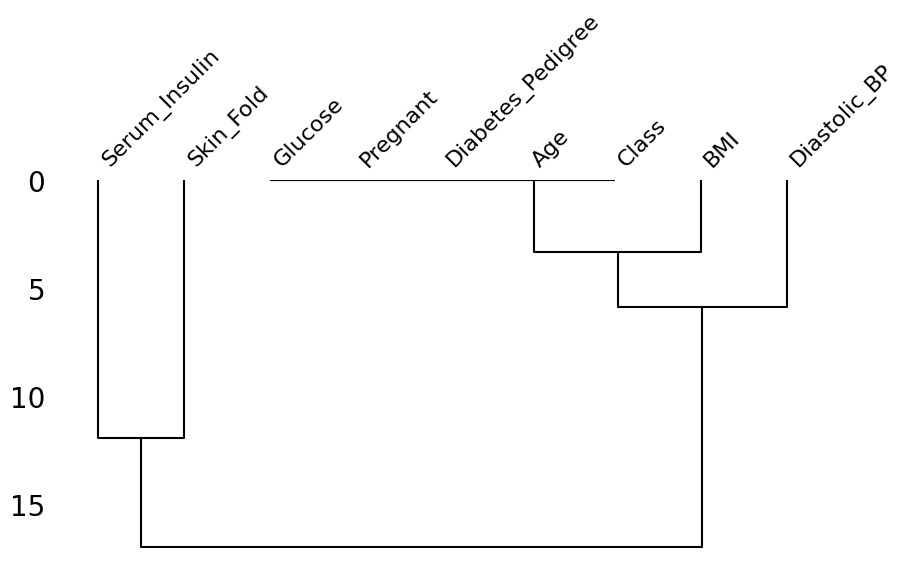

In [65]:
msno.dendrogram(df2, figsize=(10, 5));

In [66]:
df2.dropna(subset=['BMI'], how='any', inplace = True)

<ipython-input-66-795b72d187e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.dropna(subset=['BMI'], how='any', inplace = True)


In [68]:
df2.isna().sum()

Pregnant               0
Glucose                0
Diastolic_BP          28
Skin_Fold            218
Serum_Insulin        360
BMI                    0
Diabetes_Pedigree      0
Age                    0
Class                  0
dtype: int64

# Imputation on continuous variables

In [83]:
def tr_data(input_data, transformer):
  data = input_data.copy('deep')
  data.iloc[:, :] = transformer.fit_transform(data)
  return data

mean_df2 = tr_data(input_data = df2, transformer = SimpleImputer(strategy = 'mean') )
median_df2 = tr_data(input_data = df2, transformer = SimpleImputer(strategy = 'median') )
most_freq_df2 = tr_data(input_data = df2, transformer = SimpleImputer(strategy = 'most_frequent') )
constant_df2 = tr_data(input_data = df2, transformer = SimpleImputer(strategy = 'constant', fill_value = 0) )

<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :] = transformer.fit_transform(data)
<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :] = transformer.fit_transform(data)
<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.

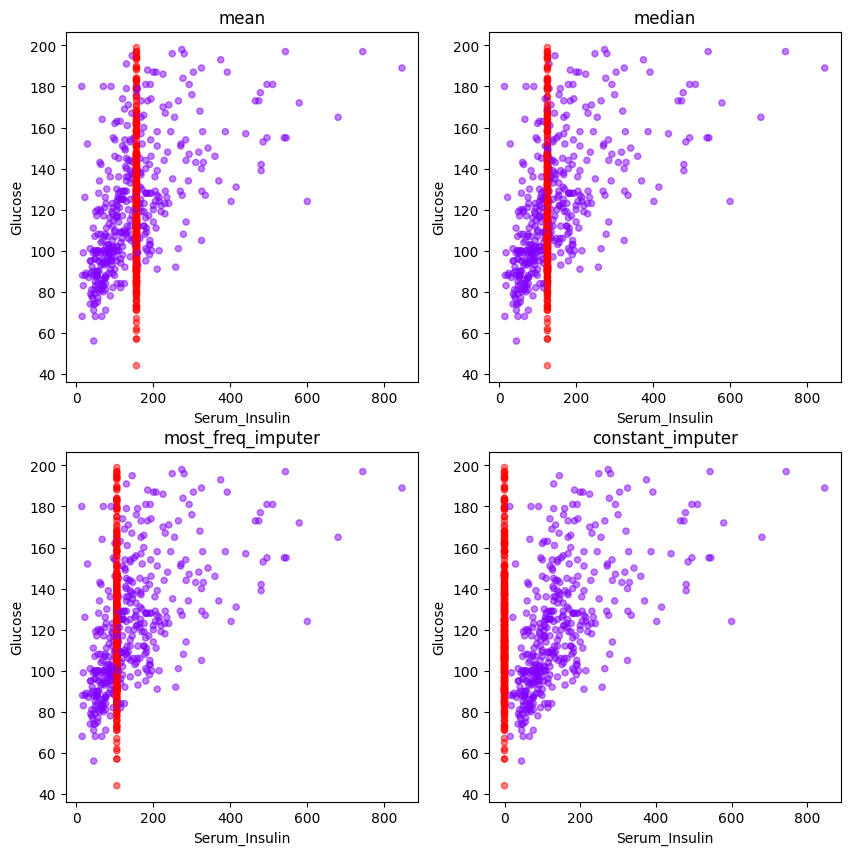

In [84]:
data_imp = {
    'mean' : mean_df2,
    'median' : median_df2,
    'most_freq_imputer' : most_freq_df2,
    'constant_imputer' : constant_df2
}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for col, ax in zip(data_imp, axs.flatten()):
  data_imp[col].plot(x='Serum_Insulin',
                     y='Glucose',
                     kind='scatter',
                     alpha=0.5,
                     c=(df2.Serum_Insulin.isnull() | df2.Glucose.isnull()),
                     cmap='rainbow',
                     ax=ax,
                     colorbar=False,
                     title=col)

In [91]:
knn_df2 = tr_data(input_data = df2, transformer = KNN() )
iterative_df2 = tr_data(input_data = df2, transformer = IterativeImputer() )

Imputing row 1/752 with 1 missing, elapsed time: 0.243
Imputing row 101/752 with 0 missing, elapsed time: 0.249
Imputing row 201/752 with 2 missing, elapsed time: 0.252
Imputing row 301/752 with 0 missing, elapsed time: 0.262
Imputing row 401/752 with 1 missing, elapsed time: 0.266
Imputing row 501/752 with 2 missing, elapsed time: 0.273
Imputing row 601/752 with 0 missing, elapsed time: 0.277
Imputing row 701/752 with 0 missing, elapsed time: 0.285


<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :] = transformer.fit_transform(data)
<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :] = transformer.fit_transform(data)


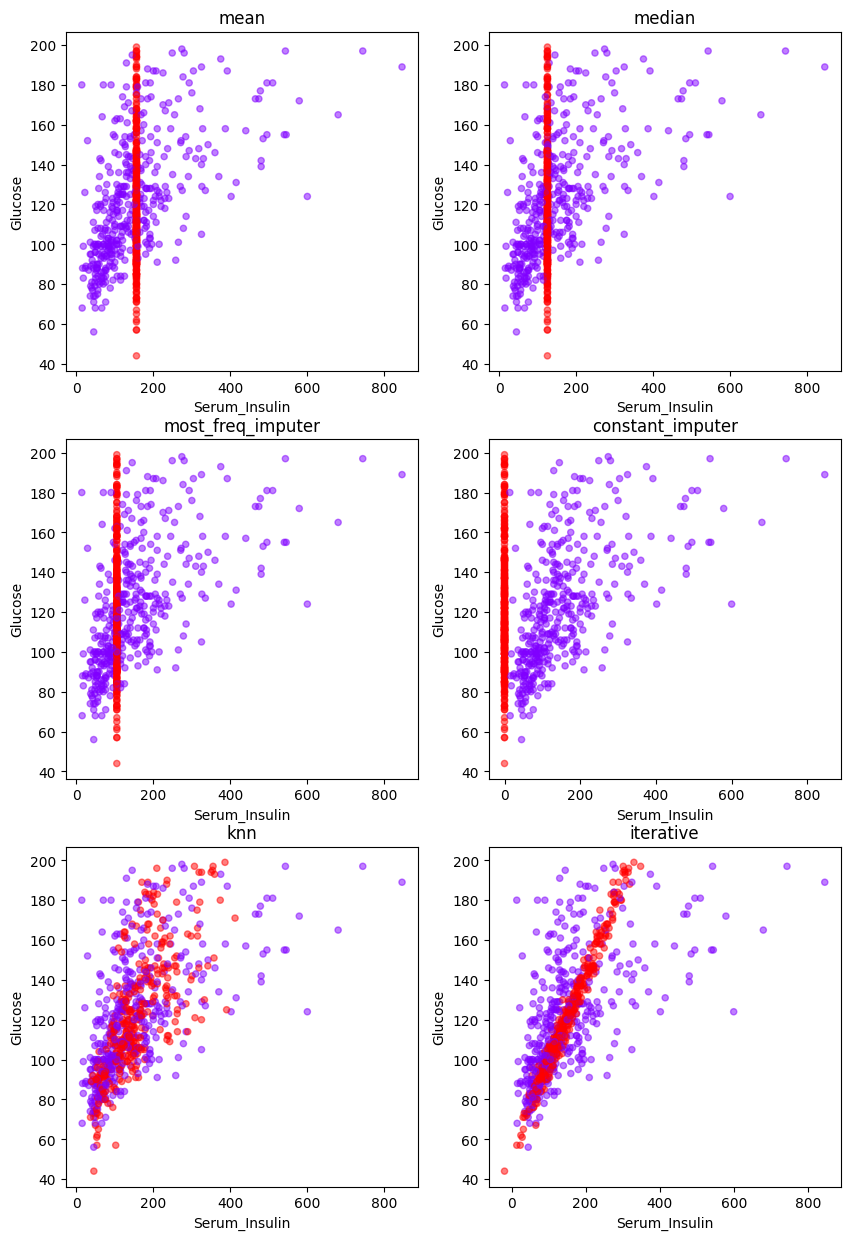

In [86]:
data_imp = {
    'mean' : mean_df2,
    'median' : median_df2,
    'most_freq_imputer' : most_freq_df2,
    'constant_imputer' : constant_df2,
    'knn': knn_df2,
    'iterative': iterative_df2
}

fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for col, ax in zip(data_imp, axs.flatten()):
  data_imp[col].plot(x='Serum_Insulin',
                     y='Glucose',
                     kind='scatter',
                     alpha=0.5,
                     c=(df2.Serum_Insulin.isnull() | df2.Glucose.isnull()),
                     cmap='rainbow',
                     ax=ax,
                     colorbar=False,
                     title=col)

In [177]:
data_imp_ext = data_imp.copy()
data_imp_ext['orig'] = df_copy

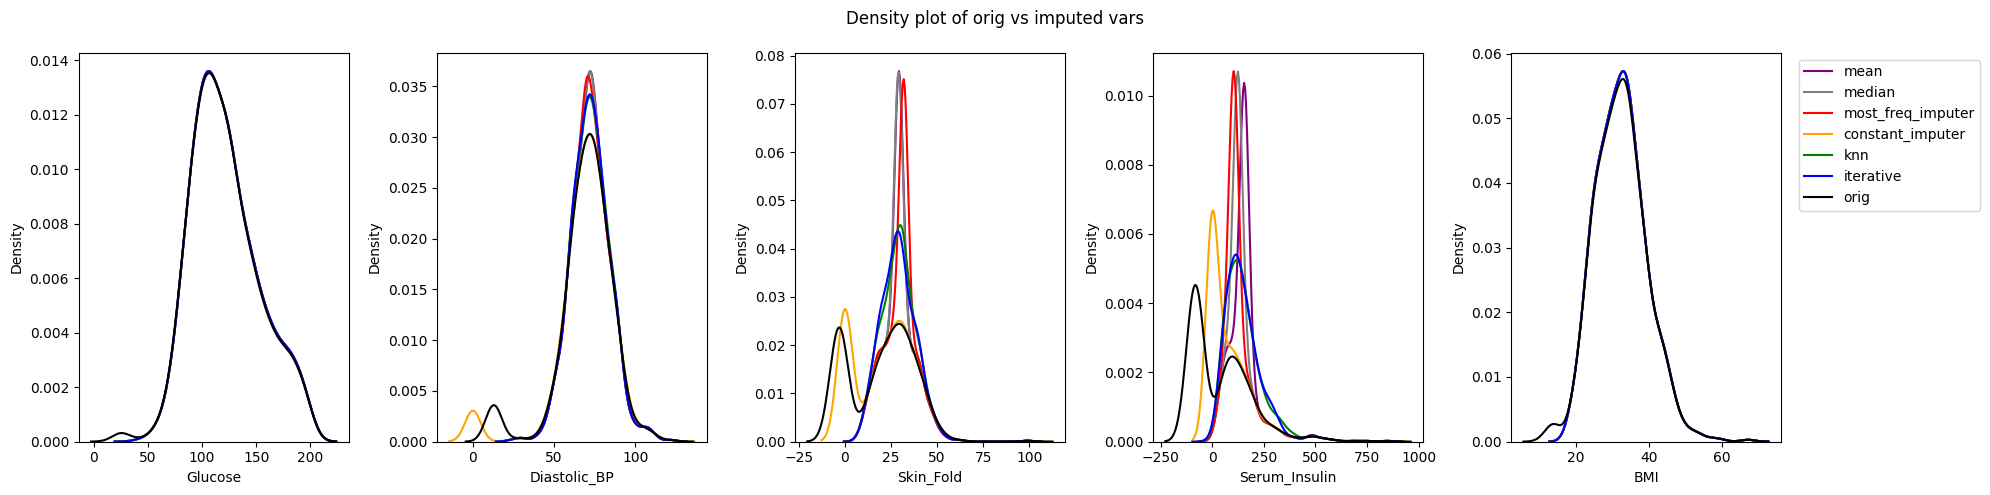

In [176]:
#fig, axs = plt.subplots(1, 5, figsize=(20,5), sharey=True)
fig, axs = plt.subplots(1, 5, figsize=(20,5))
fig.suptitle('Density plot of orig vs imputed vars')

labels = data_imp_ext.keys()
colors = ['purple', 'grey', 'red', 'orange', 'green', 'blue', 'black']

for i, (var, ax) in enumerate(zip(miss_attr, axs.flatten())):
  for j, data in enumerate(data_imp_ext.values()):
    sns.kdeplot(data,
                x = var,
                ax = ax,
                color = colors[j])

plt.legend(labels, bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

#Imputation on categorical data

In [98]:
df3 = df2.copy('deep')

In [99]:
def cat_func(x):
  if (x < 25):
    return 'small'
  elif (x >= 25 and x < 40):
    return 'medium'
  else:
    return 'hard'

df3['type1'] = df3.BMI.apply(cat_func)

In [100]:
df3.loc[((df3.BMI > 21) & (df3.BMI < 24)),'type1'] = np.nan

In [101]:
df3.head(3)

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class,type1
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0,medium
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0,medium
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0,NaN


In [104]:
obj_cols = df3.select_dtypes('object').columns
obj_cols[0]

'type1'

In [105]:
df3.type1.unique()

array(['medium', nan, 'hard', 'small'], dtype=object)

In [108]:
ord_dict = dict()
df4 = df3.copy('deep')

for col_name in obj_cols:
  col = df4.loc[:, col_name]
  miss_ind = col.isnull()
  n_miss_vals = col[~miss_ind].values.reshape(-1, 1)
  ord_dict[col_name] = OrdinalEncoder(categories=[list(col[~miss_ind].unique())] )

  df4.loc[~miss_ind,col_name] = ord_dict[col_name].fit_transform(n_miss_vals)

print(ord_dict)
df4.head(3)

{'type1': OrdinalEncoder(categories=[['medium', 'hard', 'small']])}


,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class,type1
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50,1.0,0.0
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31,0.0,0.0
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32,1.0,NaN


In [109]:
df4 = tr_data(input_data = df4, transformer = KNN() )

Imputing row 1/752 with 1 missing, elapsed time: 0.146
Imputing row 101/752 with 0 missing, elapsed time: 0.151
Imputing row 201/752 with 2 missing, elapsed time: 0.155
Imputing row 301/752 with 0 missing, elapsed time: 0.161
Imputing row 401/752 with 1 missing, elapsed time: 0.165
Imputing row 501/752 with 2 missing, elapsed time: 0.168
Imputing row 601/752 with 0 missing, elapsed time: 0.172
Imputing row 701/752 with 0 missing, elapsed time: 0.176


<ipython-input-83-b73c7eef5c44>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, :] = transformer.fit_transform(data)


In [111]:
for col_name in obj_cols:
  df4.loc[:,col_name] = ord_dict[col_name].inverse_transform(df4.loc[:,col_name].values.reshape(-1, 1))

In [112]:
df4.head(5)

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class,type1
0,6.0,148.0,72.0,35.000000,162.743264,33.6,0.627,50.0,1.0,medium
1,1.0,85.0,66.0,29.000000,63.248266,26.6,0.351,31.0,0.0,medium
2,8.0,183.0,64.0,26.464588,180.726394,23.3,0.672,32.0,1.0,medium
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0.0,medium
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1.0,hard


In [113]:
df4.isna().sum()

Pregnant             0
Glucose              0
Diastolic_BP         0
Skin_Fold            0
Serum_Insulin        0
BMI                  0
Diabetes_Pedigree    0
Age                  0
Class                0
type1                0
dtype: int64

In [114]:
data_imp_result = {}

for name in data_imp:
  X = sm.add_constant(data_imp[name].iloc[:, :-1])
  y = data_imp[name]['Class']
  lm = sm.OLS(y, X).fit()
  data_imp_result[name] = lm.rsquared_adj

data_imp_result

{'mean': 0.31233901521468155,
 'median': 0.31283648592012636,
 'most_freq_imputer': 0.31346240081383536,
 'constant_imputer': 0.319965055288043,
 'knn': 0.31322426585090235,
 'iterative': 0.312489830656391}

In [115]:
best_imputation = max(data_imp_result, key=data_imp_result.get)

print("The best imputation technique is: ", best_imputation)

The best imputation technique is:  constant_imputer
